In [1]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation_2d_compressed.h5", "r") as data:
    y = data["y"][:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = 100
y = y[index:, 0, :, :].astype(np.complex64)

In [2]:
eta_hat = y[:].copy()

modes = eta_hat.shape[-2] // 2
x = np.linspace(0, length, 2*modes)

X, Y = np.meshgrid(x, x)
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
mask_2 = ((X-1500)**2+(Y-1500)**2) < 1500**2

mask_i_left = []
mask_i_right = []
mask_i = []
mask_j = []

I, J = np.meshgrid(np.arange(0, 2*modes), np.arange(0, 2*modes))
for i in range(2*modes):
    for j in range(2*modes):
        if not mask[i, j]:
            continue

        for k in range(modes):
            if not mask[modes+k, j]:
                mask_i.append(i)
                mask_j.append(j)
                mask_i_left.append(modes+k)
                mask_i_right.append(modes-k-1)
                break

mask_2_i = []
mask_2_j = []
mask_2_i_map = []
mask_2_j_map = []
for j in range(2*modes):
    for i in range(modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i+k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i+k)
                mask_2_j_map.append(j)
                break

for j in range(2*modes):
    for i in range(modes, 2*modes):
        if mask_2[i, j]: continue
        for k in range(modes):
            if mask_2[i-k, j]:
                mask_2_i.append(i)
                mask_2_j.append(j)
                mask_2_i_map.append(i-k)
                mask_2_j_map.append(j)
                break

mask_i = np.array(mask_i)
mask_j = np.array(mask_j)
mask_i_left = np.array(mask_i_left)
mask_i_right = np.array(mask_i_right)

mask_2_i = np.array(mask_2_i)
mask_2_j = np.array(mask_2_j)
mask_2_i_map = np.array(mask_2_i_map)
mask_2_j_map = np.array(mask_2_j_map)

eta = irfft2(eta_hat).astype(np.float32)
eta[:, mask_i, mask_j] = (eta[:, mask_i_left, mask_j] + eta[:, mask_i_right, mask_j])*0.5
eta[:, mask_2_i, mask_2_j] = eta[:, mask_2_i_map, mask_2_j_map]
eta_hat = rfft2(eta).astype(np.complex64)

new_modes = 204
new_modes_hor = 100
indexes = np.concatenate((np.arange(0, modes+1), np.arange(2, modes+1)[::-1]))

mask_vert = indexes < new_modes_hor+1
mask_hor = np.arange(0, modes+1) < new_modes+1

eta_hat = eta_hat[:, mask_vert, :]
eta_hat = eta_hat[:, :, mask_hor] / modes / modes * new_modes_hor * new_modes

y = y[:, mask_vert, :]
y = y[:, :, mask_hor] / modes / modes * new_modes_hor * new_modes

In [10]:
prediction_time = 60 # 140 sec
measure_time = 60 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)
train_percentage = 0.8

X = eta_hat[:-prediction_time].copy()
y = y[prediction_time+measure_time:-1]

X = irfft2(X)
y = irfft2(y)

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize

std = np.std(X_train)
X_train = X_train / std
y_train = y_train / std

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(624, 7, 200, 408) (624, 200, 408)
(156, 7, 200, 408) (156, 200, 408)


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO2d

device = torch.device("cuda")

val_mask = np.zeros(X_train.shape[0], dtype=bool)
val_mask[:int(0.1 * X_train.shape[0])] = True
np.random.shuffle(val_mask)

# to PyTorch tensors
X_t = torch.from_numpy(X_train[~val_mask]).float()
y_t = torch.from_numpy(y_train[~val_mask]).float()

X_v = torch.from_numpy(X_train[val_mask]).float()
y_v = torch.from_numpy(y_train[val_mask]).float()

dataset = TensorDataset(X_t, y_t)
loader  = DataLoader(dataset, batch_size=25, shuffle=True)

dataset_val = TensorDataset(X_v, y_v)
loader_val  = DataLoader(dataset_val, batch_size=25, shuffle=True)

model = FNO2d(in_channels=7, out_channels=1, width=16, modes_height=30, modes_width=150, depth=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

early_stopping_rounds = 10

early_stopping_count = 0
best_loss = np.inf

x = np.linspace(0, length, 2*new_modes_hor)
y = np.linspace(0, length, 2*new_modes)
X, Y = np.meshgrid(x, y, indexing="ij")
mask = ((X-1500)**2+(Y-1500)**2) <= 200**2
loss_mask = np.ones(y_train.shape[1:])
loss_mask[mask] = 3
loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)
loss_correction = 4 * modes * modes

model.train()
for epoch in range(1, 501):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)

    total_loss_val = 0.0
    for xb, yb in loader_val:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred * loss_mask, yb * loss_mask) * loss_correction / torch.sum(loss_mask)
        total_loss_val += loss.item()
    avg_val = total_loss / len(loader_val)

    if avg_val < best_loss:
        best_loss = avg_val
        early_stopping_count = 0
        torch.save(model.state_dict(), f"results/best_FNO_2d_circ_2.pt")
        print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f} - Saving")
    else:
        print(f"Epoch: {epoch}, Loss train - {avg:.6f}, Loss val - {avg_val:.6f}")
        early_stopping_count += 1
        if early_stopping_count > early_stopping_rounds:
            print("early_stopping")
            break

Epoch: 1, Loss train - 10.989311, Loss val - 84.251381 - Saving
Epoch: 2, Loss train - 3.477036, Loss val - 26.657273 - Saving
Epoch: 3, Loss train - 1.904654, Loss val - 14.602350 - Saving
Epoch: 4, Loss train - 1.611465, Loss val - 12.354568 - Saving
Epoch: 5, Loss train - 1.438327, Loss val - 11.027177 - Saving
Epoch: 6, Loss train - 1.295598, Loss val - 9.932915 - Saving
Epoch: 7, Loss train - 1.171200, Loss val - 8.979196 - Saving
Epoch: 8, Loss train - 1.061253, Loss val - 8.136275 - Saving
Epoch: 9, Loss train - 0.961837, Loss val - 7.374081 - Saving
Epoch: 10, Loss train - 0.875576, Loss val - 6.712752 - Saving
Epoch: 11, Loss train - 0.798640, Loss val - 6.122908 - Saving
Epoch: 12, Loss train - 0.730319, Loss val - 5.599116 - Saving
Epoch: 13, Loss train - 0.669473, Loss val - 5.132623 - Saving
Epoch: 14, Loss train - 0.616593, Loss val - 4.727211 - Saving
Epoch: 15, Loss train - 0.569143, Loss val - 4.363432 - Saving
Epoch: 16, Loss train - 0.527960, Loss val - 4.047692 - Sa

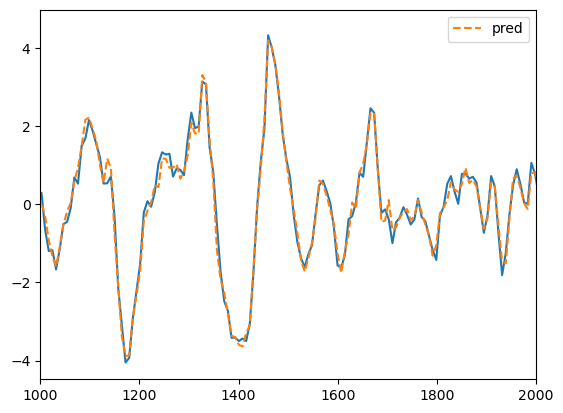

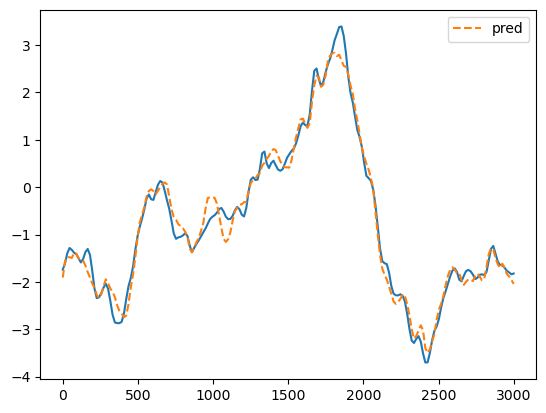

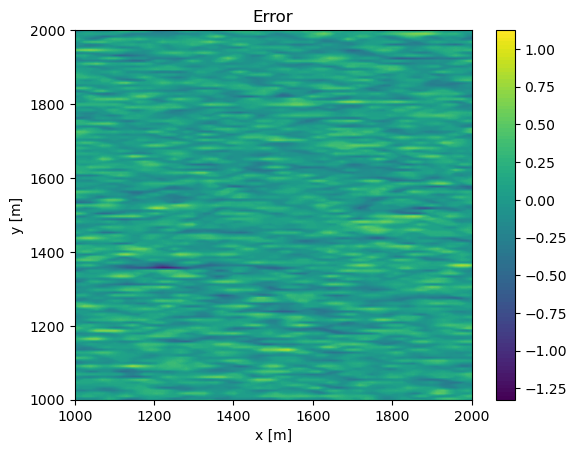

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d, FNO2d

device = torch.device("cuda")
# model = FNO2d(in_channels=2, out_channels=1, width=16, modes_height=64, modes_width=64, depth=4)
# model.load_state_dict(torch.load("best_FNO.pt", map_location=device))
model.eval()

X_tensor = torch.from_numpy(X_test / std).float().to(device)
# random_indices = torch.randperm(X_tensor.shape[0])[:9]

y_pred = None
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy() * std

error = y_pred - y_test

y = np.linspace(0, length, 2*new_modes)
x = np.linspace(0, length, 2*new_modes_hor)
plt.plot(np.linspace(0, length, 2*new_modes), y_test[0, new_modes_hor, :])
plt.plot(np.linspace(0, length, 2*new_modes), y_pred[0, new_modes_hor, :], "--", label="pred")
plt.xlim(1000, 2000)
plt.legend()
plt.show()

plt.plot(np.linspace(0, length, 2*new_modes_hor), y_test[0, :, new_modes])
plt.plot(np.linspace(0, length, 2*new_modes_hor), y_pred[0, :, new_modes], "--", label="pred")
plt.legend()
plt.show()


plt.contourf(x, y, error[0].transpose(), levels=100)
plt.colorbar()
plt.title("Error")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(1000, 2000)
plt.ylim(1000, 2000)
plt.show()

# for index in range(10):
#     plt.plot(x[mes_index_1:mes_index_2], y_pred[index, :, modes][mes_index_1:mes_index_2])
#     plt.plot(x, y_train[index, :, modes]*std_eta)
#     RMSE = np.sqrt(np.mean((y_pred[index, :, modes] - y_train[index, :, modes]*std_eta)**2))
#     plt.title(f"RMSE: {RMSE:.5f}m")
#     plt.show()

#     plt.plot(x, y_pred[index, modes, :])
#     plt.plot(x, y_train[index, modes, :]*std_eta)
#     RMSE = np.sqrt(np.mean((y_pred[index, modes, :] - y_train[index, modes, :]*std_eta)**2))
#     plt.title(f"RMSE: {RMSE:.5f}m")
#     plt.xlim(1000, 2000)
#     plt.show()

0.20092387
0.17581874


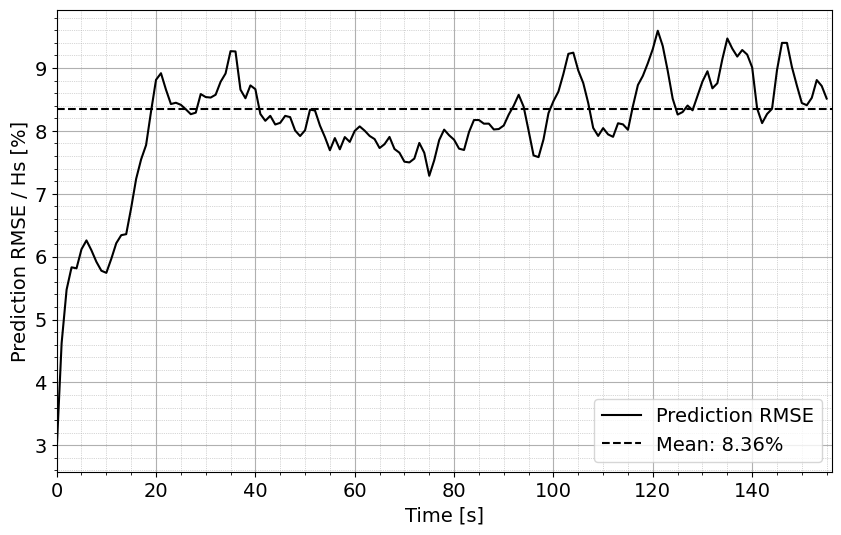

In [111]:
x = np.linspace(0, 3000, 2*new_modes_hor)
y = np.linspace(0, 3000, 2*new_modes)
X, Y = np.meshgrid(x, y, indexing="ij")
error_mask = (X-1500)**2 + (Y-1500)**2 < 200**2

cut_index_1_x = np.argmin(np.abs(x-(1500-200)))
cut_index_2_x = np.argmin(np.abs(x-(1500+200)))

# plt.plot(y_pred[0, :, new_modes])
# plt.plot(y_test[0, :, new_modes])
# plt.axvline(cut_index_1_x)
# plt.axvline(cut_index_2_x)
# plt.show()

print(np.sqrt(np.mean(error[0, cut_index_1_x:cut_index_2_x, :]**2)))
print(np.sqrt(np.mean(error[0, error_mask]**2)))
fontsize=14
fig, ax = plt.subplots(figsize=(10, 6))
error_time = np.sqrt(np.mean(error[:, error_mask]**2, axis=-1))
plt.plot(error_time/Hs*100, color="k", label="Prediction RMSE")
plt.xlim(0, error.shape[0])
plt.axhline(np.mean(error_time[30:])/Hs*100, linestyle="--", color="k", label=f"Mean: {np.mean(error_time[30:])/Hs*100:.2f}%")
plt.legend()
ax.legend(fontsize=fontsize, loc=4)
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=fontsize)
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Prediction RMSE / Hs [%]", fontsize=fontsize)
plt.savefig("results/rmse_time_2d_ml.pdf", dpi=300, bbox_inches='tight')
plt.show()


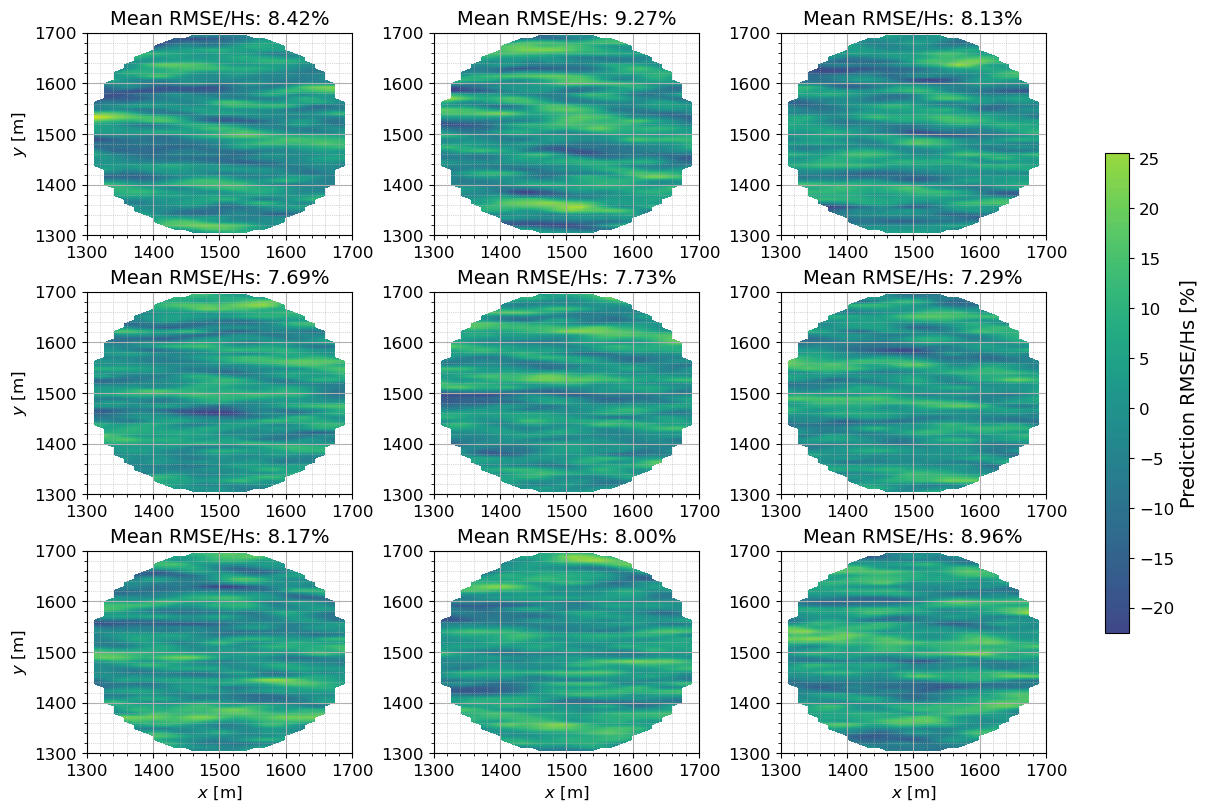

In [110]:
import matplotlib.pyplot as plt
import numpy as np

error_nan = error.copy()
error_nan[:, ~error_mask] = np.nan

# Sample setup (replace with your real data)
# x, y = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
# error_nan = [np.random.rand(100, 100) for _ in range(9)]

fontsize = 12  # adjust as needed

fig, axes = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)

# Create contourf plots
vmin = np.nanmin(error_nan)/Hs*100
vmax = np.nanmax(error_nan)/Hs*100

for idx, ax in enumerate(axes.flat):
    index = 25+idx*10
    cf = ax.contourf(x, y, error_nan[index].T/Hs*100, levels=100, vmin=vmin, vmax=vmax, cmap='viridis')

    ax.set_xlim(1300, 1700)
    ax.set_ylim(1300, 1700)
    ax.grid(True, which='major', linewidth=0.8)
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=fontsize)
    RMSE = np.sqrt(np.mean(error[index, error_mask]**2))/Hs*100
    ax.set_title(f"Mean RMSE/Hs: {RMSE:.2f}%", fontsize=fontsize+2)

for i in range(3):
    for j in range(3):
        # if i == 0 and j == 0:
            # axes[i, j].legend(fontsize=fontsize)

        if i == 2:
            axes[i, j].set_xlabel('$x$ [m]', fontsize=fontsize)

        if j == 0:
            axes[i, j].set_ylabel(fr"$y$ [m]", fontsize=fontsize)

cbar = fig.colorbar(cf, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label("Prediction RMSE/Hs [%]", fontsize=fontsize+2)
plt.savefig("results/2d_ml_example.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
d